In [1]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

np.set_printoptions(precision=3)

In [2]:
class Agent:
    def __init__(self):
        pass
    
    def act(self, state):
        # Simple-minded agent that always select action 1
        return 1

In [3]:
class Car:
    def __init__(self, tyre="Intermediate"):
        self.default_tyre = tyre
        self.possible_tyres = ["Ultrasoft", "Soft", "Intermediate", "Fullwet"]
        self.pitstop_time = 23
        self.fuel_capacity = 100.0  # Maximum fuel capacity
        self.fuel_consumption_rate = 0.01  # Fuel consumption rate per unit distance
        self.pitstop_time_refuel = 40  # Additional time for refueling during pitstop
        self.refuel_time = 15  # Time needed to refuel
        self.current_refuel_time = 0
        self.reset()
        
    def change_tyre(self, new_tyre):
        # change car's tyre
        assert new_tyre in self.possible_tyres
        self.tyre = new_tyre
        self.condition = 1.0
        self.current_refuel_time = 0
        
    def reset(self):
        self.change_tyre(self.default_tyre)
        self.fuel_level = self.fuel_capacity
        self.current_refuel_time = 0  # Reset refueling time
        
    def degrade(self, w, r):
        if self.tyre == "Ultrasoft":
            self.condition *= (1 - 0.0050*w - (2500-r)/90000)
        elif self.tyre == "Soft":
            self.condition *= (1 - 0.0051*w - (2500-r)/93000)
        elif self.tyre == "Intermediate":
            self.condition *= (1 - 0.0052*abs(0.5-w) - (2500-r)/95000)
        elif self.tyre == "Fullwet":
            self.condition *= (1 - 0.0053*(1-w) - (2500-r)/97000)
            
    def get_velocity(self, driving_style):
        # Calculate car velocity based on tire, condition, fuel level, and driving style
        base_velocity = 0
        if self.tyre == "Ultrasoft":
            base_velocity = 80.7
        elif self.tyre == "Soft":
            base_velocity = 80.1
        elif self.tyre == "Intermediate":
            base_velocity = 79.5
        elif self.tyre == "Fullwet":
            base_velocity = 79.0
        # Adjust velocity and fuel consumption based on driving style
        if driving_style == 1:
            velocity = base_velocity * (0.8 * self.condition**1.5) * (self.fuel_level / self.fuel_capacity)
        elif driving_style == 2:
            velocity = base_velocity * (0.6 * self.condition**1.5) * (self.fuel_level / self.fuel_capacity)
        elif driving_style == 3:
            velocity = base_velocity * (0.4 * self.condition**1.5) * (self.fuel_level / self.fuel_capacity)

        return velocity    

In [4]:
class Track:
    def __init__(self, car=Car()):
        self.total_laps = 162
        self.car = car
        self.possible_weather = ["Dry", "20% Wet", "40% Wet", "60% Wet", "80% Wet", "100% Wet"]
        self.wetness = {
            "Dry": 0.00, "20% Wet": 0.20, "40% Wet": 0.40, "60% Wet": 0.60, "80% Wet": 0.80, "100% Wet": 1.00
        }
        self.p_transition = {
            "Dry": {
                "Dry": 0.987, "20% Wet": 0.013, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "20% Wet": {
                "Dry": 0.012, "20% Wet": 0.975, "40% Wet": 0.013, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "40% Wet": {
                "Dry": 0.000, "20% Wet": 0.012, "40% Wet": 0.975, "60% Wet": 0.013, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "60% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.012, "60% Wet": 0.975, "80% Wet": 0.013, "100% Wet": 0.000
            },
            "80% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.012, "80% Wet": 0.975, "100% Wet": 0.013
            },
            "100% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.012, "100% Wet": 0.988
            }
        }        
        # Initialize cur_weather
        self.reset()

    def reset(self):
        # Reset track parameters
        self.radius = np.random.randint(600, 1201)
        self.cur_weather = np.random.choice(self.possible_weather)
        self.is_done = False
        self.pitstop = False
        self.laps_cleared = 0
        self.car.reset()
        return self._get_state()

    def _get_state(self):
        # Return the current state
        return [self.car.tyre, self.car.condition, self.car.fuel_level, self.cur_weather, self.radius, self.laps_cleared]

    def transition(self, action=0, driving_style=1, refuel=False):
        time_taken = 0

        # Check for pitstops
        if self.laps_cleared == int(self.laps_cleared):
            if self.pitstop:
                self.car.change_tyre(self.committed_tyre)
                time_taken += self.car.pitstop_time
                self.pitstop = False

        # Check if an action is needed at the start of the three-quarters mark of each lap
        if self.laps_cleared - int(self.laps_cleared) == 0.75:
            if action < 4:
                self.pitstop = True
                self.committed_tyre = self.car.possible_tyres[action]
            else:
                self.pitstop = False

        # Update weather conditions
        self.cur_weather = np.random.choice(
            self.possible_weather, p=list(self.p_transition[self.cur_weather].values())
        )

        # Calculate distance traveled and velocity
        velocity = self.car.get_velocity(driving_style)
        distance = (2 * np.pi * self.radius / 8)

        # Add a check to avoid division by zero
        if velocity > 0:
            time_taken += distance / velocity
        else:
            # Handle the case where velocity is zero (or negative)
            time_taken += 1.0  # You can choose a default time increment when velocity is zero or negative

        # Apply degradation and fuel consumption
        self.car.degrade(w=self.wetness[self.cur_weather], r=self.radius)
        fuel_consumed = distance * self.car.fuel_consumption_rate
        self.car.fuel_level -= fuel_consumed

        reward = 0 - time_taken

        # Calculate crash probability based on driving style and fuel level
        crash_probability = self.calculate_crash_probability(velocity, driving_style)
        if np.random.random() < crash_probability:
            # Car crashes, apply a massive negative reward
            reward -= 1000

        # Implement rewards/penalties based on fuel efficiency
        if fuel_consumed > 0:
            reward -= fuel_consumed

        # Apply time penalty for refueling during pitstop
        if refuel:
            time_taken += self.car.pitstop_time_refuel

        # Check if the race is finished
        if self.laps_cleared == self.total_laps:
            self.is_done = True

        next_state = self._get_state()
        return reward, next_state, self.is_done, velocity

    def calculate_crash_probability(self, velocity, driving_style):
        # Calculate crash probability based on velocity, wetness, driving style, and fuel level
        crash_probability = 0.01 * (velocity - 80) + 0.05 * self.wetness[self.cur_weather]

        # Adjust crash probability based on driving style and low fuel level
        if driving_style == 1:
            crash_probability += 0.02 * (100 - self.car.fuel_level)
        elif driving_style == 3:
            crash_probability -= 0.01 * (100 - self.car.fuel_level)

        return crash_probability

In [6]:
class QLearningAgent:
    def __init__(self, n_actions=5, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = {}

    def _discretize_state(self, state):
        tyre, condition, fuel_level, cur_weather, radius, laps_cleared = state
        return (tyre, round(condition, 2), cur_weather, radius, int(laps_cleared))

    def act(self, state):
        discrete_state = self._discretize_state(state)
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.randint(self.n_actions)
        return np.argmax(self.get_q_values(discrete_state))

    def get_q_values(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.n_actions)
        return self.q_table[state]

    def update(self, state, action, reward, next_state):
        discrete_state = self._discretize_state(state)
        discrete_next_state = self._discretize_state(next_state)
        current_q = self.get_q_values(discrete_state)[action]
        next_max_q = np.max(self.get_q_values(discrete_next_state))
        self.q_table[discrete_state][action] = (1 - self.alpha) * current_q + self.alpha * (reward + self.gamma * next_max_q)

In [7]:
# Simulation with Q-learning
new_car = Car()
env = Track(new_car)

agent = QLearningAgent()

EPISODES = 1000

# Define different parameter sets
parameter_sets = [
    {"alpha": 0.1, "gamma": 0.99, "epsilon": 0.1},
    {"alpha": 0.2, "gamma": 0.9, "epsilon": 0.1},
    {"alpha": 0.05, "gamma": 1, "epsilon": 0.05},
    {"alpha": 0.1, "gamma": 0.8, "epsilon": 0.01},
    {"alpha": 0.1, "gamma": 0.9, "epsilon": 0.03},
    {"alpha": 0.3, "gamma": 0.8, "epsilon": 0.1},
    {"alpha": 0.2, "gamma": 0.9, "epsilon": 0.05},
    {"alpha": 0.3, "gamma": 0.7, "epsilon": 0.1},
    {"alpha": 0.4, "gamma": 0.85, "epsilon": 0.1},
    {"alpha": 0.3, "gamma": 0.1, "epsilon": 0.1},
    {"alpha": 0.2, "gamma": 0, "epsilon": 0.1},
    {"alpha": 0.2, "gamma": 0.4, "epsilon": 0.05},
    {"alpha": 0.3, "gamma": 0.7, "epsilon": 0.1},
    {"alpha": 0.4, "gamma": 0.5, "epsilon": 0.1}
]

α=0.4, γ=0.5, ε=0.1: 100%|██████████| 1000/1000 [00:46<00:00, 21.41it/s]


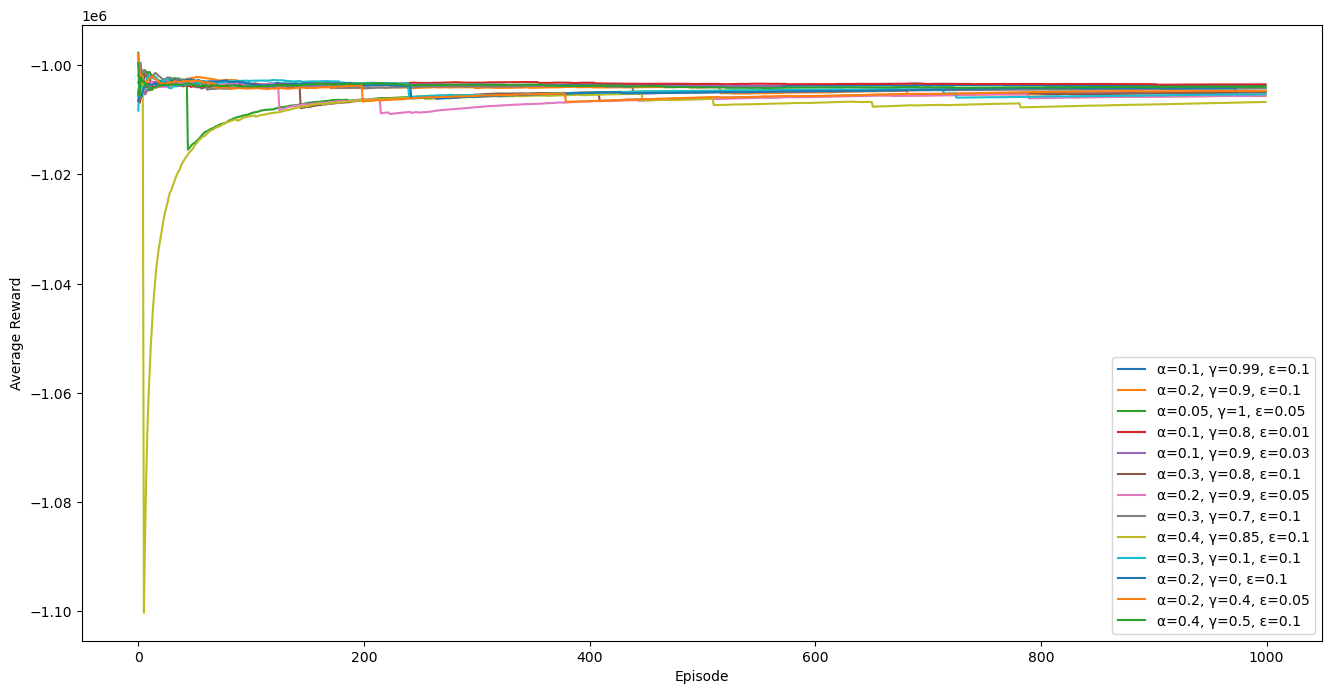

In [13]:
from tqdm import tqdm

results = {}

for params in parameter_sets:
    # Initialize agent with current parameters
    agent = QLearningAgent(n_actions=5, alpha=params["alpha"], gamma=params["gamma"], epsilon=params["epsilon"])

    avg_rewards = []
    running_sum = 0

    with tqdm(total=EPISODES, desc=f'α={params["alpha"]}, γ={params["gamma"]}, ε={params["epsilon"]}') as pbar:
        for episode in range(EPISODES):
            state = env.reset()
            done = False
            G = 0

            for step in range(1000):  # Limit the episode length to 1000 steps
                action = agent.act(state)
                reward, next_state, done, _ = env.transition(action)
                agent.update(state, action, reward, next_state)
                state = next_state
                G += reward

                if done:
                    break

            running_sum += G
            avg_reward = running_sum / (episode + 1)
            avg_rewards.append(avg_reward)
            pbar.update(1)  # Update the parameter-specific progress bar

    # Store average rewards for this parameter set
    param_label = f'α={params["alpha"]}, γ={params["gamma"]}, ε={params["epsilon"]}'
    results[param_label] = avg_rewards

# Plot results
plt.figure(figsize=(16, 8))
for param_label, avg_rewards in results.items():
    plt.plot(avg_rewards, label=param_label)

plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()
plt.show()

## Another Approach 

In [33]:
class Agent:
    def __init__(self):
        pass
    
    def act(self, state):
        # Simple-minded agent that always select action 1
        return 1

In [22]:
class Car:
    def __init__(self, tyre="Intermediate"):
        self.default_tyre = tyre
        self.possible_tyres = ["Ultrasoft", "Soft", "Intermediate", "Fullwet"]
        self.pitstop_time = 23
        self.fuel_capacity = 100.0  # Maximum fuel capacity
        self.fuel_consumption_rate = 0.01  # Fuel consumption rate per unit distance
        self.reset()

    def reset(self):
        self.change_tyre(self.default_tyre)
        self.fuel_level = self.fuel_capacity
        
    def degrade(self, w, r):
        if self.tyre == "Ultrasoft":
            self.condition *= (1 - 0.0050 * w - (2500 - r) / 90000)
        elif self.tyre == "Soft":
            self.condition *= (1 - 0.0051 * w - (2500 - r) / 93000)
        elif self.tyre == "Intermediate":
            self.condition *= (1 - 0.0052 * abs(0.5 - w) - (2500 - r) / 95000)
        elif self.tyre == "Fullwet":
            self.condition *= (1 - 0.0053 * (1 - w) - (2500 - r) / 97000)
        
        
    def change_tyre(self, new_tyre):
        # Change car's tires
        assert new_tyre in self.possible_tyres
        self.tyre = new_tyre
        self.condition = 1.0
    
    
    def get_velocity(self, driving_style):
        # Calculate car velocity based on tire, condition, fuel level, and driving style
        base_velocity = 0
        if self.tyre == "Ultrasoft":
            base_velocity = 80.7
        elif self.tyre == "Soft":
            base_velocity = 80.1
        elif self.tyre == "Intermediate":
            base_velocity = 79.5
        elif self.tyre == "Fullwet":
            base_velocity = 79.0
        
        # Adjust velocity based on fuel level and driving style
        if driving_style == 1:
            velocity = base_velocity * (0.8 * self.condition ** 1.5) * (self.fuel_level / self.fuel_capacity)
        elif driving_style == 2:
            velocity = base_velocity * (0.6 * self.condition ** 1.5) * (self.fuel_level / self.fuel_capacity)
        elif driving_style == 3:
            velocity = base_velocity * (0.4 * self.condition ** 1.5) * (self.fuel_level / self.fuel_capacity)
        return velocity

In [23]:
class Track:
    def __init__(self, car=Car()):
        self.total_laps = 162
        self.car = car
        self.possible_weather = ["Dry", "20% Wet", "40% Wet", "60% Wet", "80% Wet", "100% Wet"]
        self.wetness = {
            "Dry": 0.00, "20% Wet": 0.20, "40% Wet": 0.40, "60% Wet": 0.60, "80% Wet": 0.80, "100% Wet": 1.00
        }
        self.p_transition = {
            "Dry": {
                "Dry": 0.987, "20% Wet": 0.013, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "20% Wet": {
                "Dry": 0.012, "20% Wet": 0.975, "40% Wet": 0.013, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "40% Wet": {
                "Dry": 0.000, "20% Wet": 0.012, "40% Wet": 0.975, "60% Wet": 0.013, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "60% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.012, "60% Wet": 0.975, "80% Wet": 0.013, "100% Wet": 0.000
            },
            "80% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.012, "80% Wet": 0.975, "100% Wet": 0.013
            },
            "100% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.012, "100% Wet": 0.988
            }
        }        
        # Initialize cur_weather
        self.reset()

    def reset(self):
        # Reset track parameters
        self.radius = np.random.randint(600, 1201)
        self.cur_weather = np.random.choice(self.possible_weather)
        self.is_done = False
        self.pitstop = False
        self.laps_cleared = 0
        self.car.reset()
        self.agent_risk_level = 0.1  # Adjust this based on the agent's risk-taking level
        return self._get_state()

    def _get_state(self):
        # Return the current state
        return [self.car.tyre, self.car.condition, self.car.fuel_level, self.cur_weather, self.radius, self.laps_cleared, self.car.fuel_capacity]

    def transition(self, action=0, driving_style=1):
        time_taken = 0

        # Check for pitstops
        if self.laps_cleared == int(self.laps_cleared):
            if self.pitstop:
                self.car.change_tyre(self.committed_tyre)
                time_taken += self.car.pitstop_time
                
                if action >= 4:  # Refuel action
                    refuel_time = 5  # Adjust refuel time as needed
                    time_taken += refuel_time

                self.pitstop = False

        # Check if an action is needed at the start of the three-quarters mark of each lap
        if self.laps_cleared - int(self.laps_cleared) == 0.75:
            if action < 4:
                self.pitstop = True
                self.committed_tyre = self.car.possible_tyres[action]
            else:
                self.pitstop = False

        # Update weather conditions
        self.cur_weather = np.random.choice(
            self.possible_weather, p=list(self.p_transition[self.cur_weather].values())
        )

        # Calculate distance traveled and velocity
        velocity = self.car.get_velocity(driving_style)
        distance = (2 * np.pi * self.radius / 8)

        # Add a check to avoid division by zero
        if velocity > 0:
            time_taken += distance / velocity
        else:
            # Handle the case where velocity is zero (or negative)
            time_taken += 1.0  # You can choose a default time increment when velocity is zero or negative

        # Apply degradation and fuel consumption
        self.car.degrade(w=self.wetness[self.cur_weather], r=self.radius)
        fuel_consumed = distance * self.car.fuel_consumption_rate
        self.car.fuel_level -= fuel_consumed

        reward = 0 - time_taken

        # Implement crash scenarios based on crash probability
        crash_probability = self.calculate_crash_probability(velocity)
        if np.random.random() < crash_probability:
            # Car crashes, apply a massive negative reward
            reward -= 1000

        # Adjust crash-related rewards based on agent's risk level
        reward -= self.agent_risk_level * reward

        # Implement rewards/penalties based on fuel efficiency
        if fuel_consumed > 0:
            reward -= fuel_consumed

        # Check if the race is finished
        if self.laps_cleared == self.total_laps:
            self.is_done = True

        next_state = self._get_state()
        return reward, next_state, self.is_done, velocity

    def calculate_crash_probability(self, velocity):
        # Calculate crash probability based on velocity, wetness, and other factors
        crash_probability = 0.01 * (velocity - 80) + 0.05 * self.wetness[self.cur_weather]
        return crash_probability

In [24]:
class QLearningAgent:
    def __init__(self, n_actions=5, alpha=0.1, gamma=0.99, epsilon=0.1, risk_level=0.1):
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.risk_level = risk_level
        self.q_table = {}

    def _discretize_state(self, state):
        tyre, condition, fuel_level, cur_weather, radius, laps_cleared, fuel_capacity = state
        return (tyre, round(condition, 2), cur_weather, radius, int(laps_cleared), fuel_level, fuel_capacity)

    def act(self, state):
        discrete_state = self._discretize_state(state)
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.randint(self.n_actions)
        return np.argmax(self.get_q_values(discrete_state))

    def get_q_values(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.n_actions)
        return self.q_table[state]

    def update(self, state, action, reward, next_state):
        discrete_state = self._discretize_state(state)
        discrete_next_state = self._discretize_state(next_state)
        current_q = self.get_q_values(discrete_state)[action]
        next_max_q = np.max(self.get_q_values(discrete_next_state))
        self.q_table[discrete_state][action] = (1 - self.alpha) * current_q + self.alpha * (reward + self.gamma * next_max_q)

# Simulation with Q-learning
new_car = Car()
env = Track(new_car)

agent = QLearningAgent()

EPISODES = 1000

# Define different parameter sets
parameter_sets = [
    {"alpha": 0.1, "gamma": 0.99, "epsilon": 0.1},
    {"alpha": 0.2, "gamma": 0.9, "epsilon": 0.1},
    {"alpha": 0.05, "gamma": 1, "epsilon": 0.05},
    {"alpha": 0.1, "gamma": 0.8, "epsilon": 0.01},
    {"alpha": 0.1, "gamma": 0.9, "epsilon": 0.03},
    {"alpha": 0.3, "gamma": 0.8, "epsilon": 0.1},
    {"alpha": 0.2, "gamma": 0.9, "epsilon": 0.05},
    {"alpha": 0.3, "gamma": 0.7, "epsilon": 0.1},
    {"alpha": 0.4, "gamma": 0.85, "epsilon": 0.1},
    {"alpha": 0.3, "gamma": 0.1, "epsilon": 0.1},
    {"alpha": 0.2, "gamma": 0, "epsilon": 0.1},
    {"alpha": 0.2, "gamma": 0.4, "epsilon": 0.05},
    {"alpha": 0.3, "gamma": 0.7, "epsilon": 0.1},
    {"alpha": 0.4, "gamma": 0.5, "epsilon": 0.1}
]

α=0.4, γ=0.5, ε=0.1: 100%|██████████| 1000/1000 [00:50<00:00, 19.86it/s]


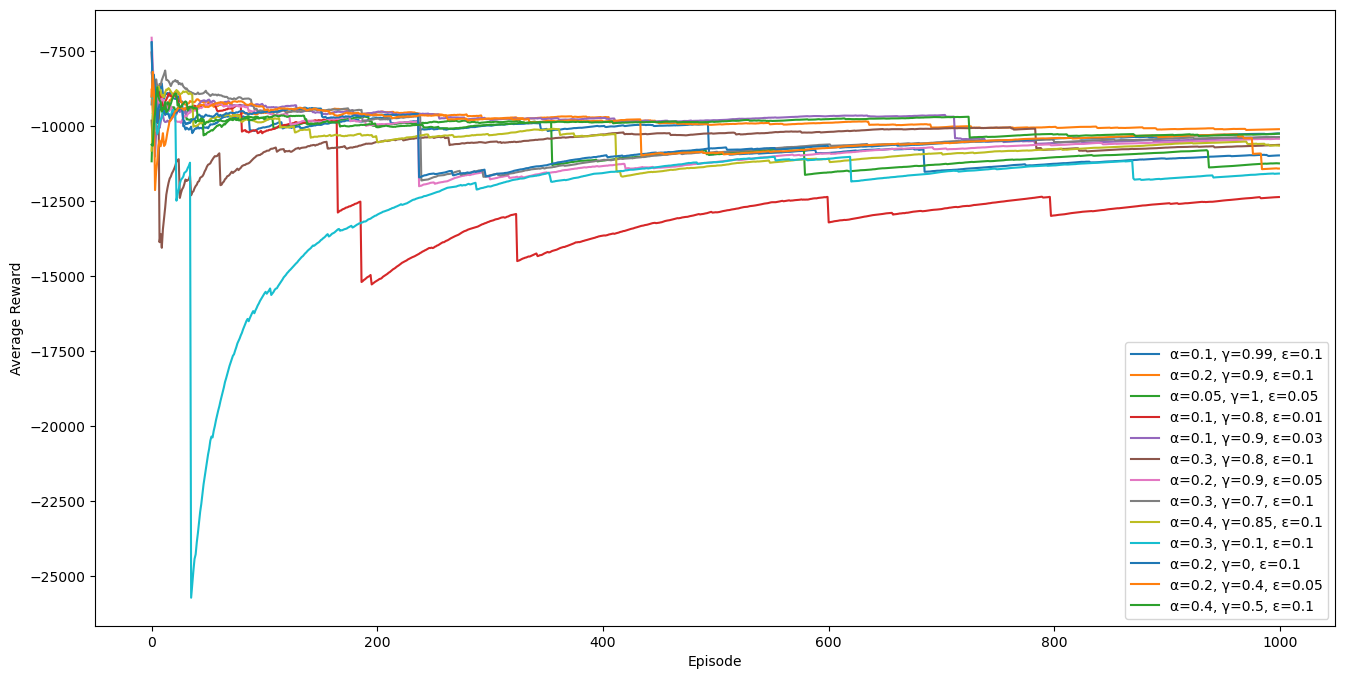

In [28]:
results = {}

for params in parameter_sets:
    # Initialize agent with current parameters
    agent = QLearningAgent(alpha=params["alpha"], gamma=params["gamma"], epsilon=params["epsilon"])

    avg_rewards = []
    running_sum = 0

    for episode in tqdm(range(EPISODES), desc=f'α={params["alpha"]}, γ={params["gamma"]}, ε={params["epsilon"]}'):
        state = env.reset()
        done = False
        G = 0

        for step in range(EPISODES):  # Use a simple step counter
            action = agent.act(state)
            reward, next_state, done, _ = env.transition(action)
            agent.update(state, action, reward, next_state)
            state = next_state
            G += reward

            if done:
                break

        running_sum += G
        avg_reward = running_sum / (episode + 1)
        avg_rewards.append(avg_reward)

    # Store average rewards for this parameter set
    param_label = f'α={params["alpha"]}, γ={params["gamma"]}, ε={params["epsilon"]}'
    results[param_label] = avg_rewards

# Plot results
plt.figure(figsize=(16, 8))
for param_label, avg_rewards in results.items():
    plt.plot(avg_rewards, label=param_label)

plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()
plt.show()